In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
The first command sets the maximum number of columns to display in a pandas DataFrame to be unlimited,
which is useful when dealing with large datasets.

The second command sets the default size of figures in Seaborn, a popular visualization library in Python,
to be 11 inches in width and 4 inches in height. This can be adjusted to suit the user's preference or
specific visualization needs.
'''
pd.options.display.max_columns = None
sns.set(rc={'figure.figsize':(11,4)}) # for plot

In [3]:
metadata = pd.read_excel("dataset.xls")
metadata.head()

,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Satisfied with living conditions,Living with a partner/child,Parental home,Having only one parent,At least one parent unemployed,Siblings,Long commute,Mode of transportation,Financial difficulties,Grant,Additional income,Public health insurance,Private health insurance,C.M.U.,Irregular rhythm of meals,Unbalanced meals,Eating junk food,On a diet,Irregular rhythm or unbalanced meals,Physical activity(3 levels),Physical activity(2 levels),Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),Diastolic blood pressure (mmHg),Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Distant visual acuity of right eye (score /10),Distant visual acuity of left eye (score /10),Close visual acuity of right eye (score /10),Close visual acuity of left eye (score /10),Decreased in distant visual acuity,Decreased in close visual acuity,Urinalysis (glycosuria),Urinalysis (proteinuria),Urinalysis (hematuria),Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Vaccination up to date,Control examination needed,Anxiety symptoms,Panic attack symptoms,Depressive symptoms,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Binge drinking,Marijuana use,Other recreational drugs
0,20 and more,female,yes,humanities,second,no,no,yes,yes,yes,no,no,no,no,yes,no,on foot,no,yes,no,yes,no,no,yes,no,yes,no,yes,regularly,regularly,62.0,165.0,no,NaN,6.0,NaN,75.0,no,10,10,10,10,no,no,no,no,no,yes,no,yes,NaN,yes,no,no,no,no,no,no,no or occasionally,no,no,no
1,19,female,yes,humanities,second,no,no,yes,yes,yes,no,yes,no,no,no,yes,by public transportation,no,yes,no,yes,yes,no,no,no,yes,no,no,regularly,regularly,57.0,170.0,no,10.0,5.0,no,65.0,no,10,10,10,10,no,no,no,no,yes,yes,no,yes,NaN,no,no,no,no,regularly,occasionally to regularly,occasionally,no or occasionally,no,no,no
2,20 and more,female,yes,humanities,second,no,no,yes,yes,yes,no,no,yes,no,yes,no,by car,no,yes,yes,yes,yes,no,yes,no,yes,no,yes,no,no activity or occasionally,NaN,162.0,NaN,11.0,7.0,no,65.0,no,10,10,10,10,no,no,no,no,no,no,no,no,NaN,no,no,no,yes,no,no,occasionally,no or occasionally,no,no,no
3,19,female,yes,humanities,second,no,no,yes,yes,yes,no,no,no,no,no,no,on foot,no,yes,no,yes,yes,no,no,no,yes,no,no,no,no activity or occasionally,85.0,193.0,no,11.0,8.0,no,70.0,no,10,10,10,10,no,no,no,no,no,yes,no,yes,NaN,no,no,no,no,no,no,occasionally,no or occasionally,no,no,no
4,18,female,yes,humanities,second,no,no,yes,yes,yes,no,no,no,no,yes,no,on foot,no,yes,no,yes,yes,no,no,no,yes,no,no,no,no activity or occasionally,41.0,161.0,no,10.0,6.0,no,NaN,NaN,10,10,10,10,no,no,no,no,yes,no,no,yes,yes,no,no,no,no,no,no,no,no or occasionally,no,no,no


# Preprocessing

In [4]:
feat_columns = metadata.columns[metadata.notna().all()].tolist()
selected_features = metadata[feat_columns]

# select all parameters with missing data
missing_data_columns = metadata.columns[metadata.isna().any()].tolist()
missing_data = metadata[missing_data_columns]

In [5]:
'''
Create new DataFrame named "dummy_feat" by applying one-hot encoding to the 'Depressive symptoms' and 'Anxiety symptoms'
columns of the 'selected' DataFrame using the "pd.get_dummies()" function. This creates new columns for each unique value
in the original columns.
'''
dummy_feat = pd.get_dummies(selected_features[['Depressive symptoms','Anxiety symptoms']])
selected_features = selected_features.join(dummy_feat)
selected_features.drop(labels=['Depressive symptoms','Anxiety symptoms'], axis=1, inplace=True)
dummy_feat.head()

,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes
0,1,0,1,0
1,1,0,1,0
2,0,1,1,0
3,1,0,1,0
4,1,0,1,0


In [6]:
'''
Parameters with object values are filtered to replace their string
values with numeric equalent through Label encoder.
Dictionary named "dummy_encoder" stores instances of the LabelEncoder class for each object type column
in a DataFrame named "selected".
For each object column, the code initializes a LabelEncoder object named "le", and then applies the fit_transform
method to the column after converting it to a string data type using the "astype" method. This encodes each
unique value in the column as a numerical label, which can be used as input to machine learning models.

The encoded values are stored in the same column in "selected". Finally, the LabelEncoder instance is added to
the "dummy_encoder" dictionary using the column name as the key. This allows for easy reference to the LabelEncoder
instances later on, if needed.
'''

# for features
features_obj_columns = list(selected_features.select_dtypes(include='object').columns)
features_encoder = {}
for col in features_obj_columns:
    le = LabelEncoder()
    selected_features.loc[:,col] = le.fit_transform(selected_features[col].astype(str))
    features_encoder[col] = le
    
# for missing data
# because label encoder will encode even nan value, so to preserve it
# first we filter out nan data, then we train encoder by skipping nan rows, 
# then create copy of that column and transform str data by skipping nan rows
missing_obj_columns = list(missing_data.select_dtypes(include='object').columns)
missing_encoder = {}
for col in missing_obj_columns:
    le = LabelEncoder()
    nan_mask = missing_data[col].isna()
    le.fit_transform(missing_data[col][~nan_mask])
    col_copy = missing_data[col].copy()
    col_copy.loc[~nan_mask] = le.transform(missing_data[col][~nan_mask])
    missing_data.loc[:,col] = col_copy.astype('float64')
    missing_encoder[col] = le

In [7]:
selected_features.head()

,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Living with a partner/child,At least one parent unemployed,Siblings,Financial difficulties,Grant,Additional income,Public health insurance,C.M.U.,Irregular rhythm of meals,Unbalanced meals,Eating junk food,On a diet,Irregular rhythm or unbalanced meals,Physical activity(3 levels),Physical activity(2 levels),Distant visual acuity of right eye (score /10),Distant visual acuity of left eye (score /10),Close visual acuity of right eye (score /10),Close visual acuity of left eye (score /10),Decreased in distant visual acuity,Decreased in close visual acuity,Urinalysis (glycosuria),Urinalysis (proteinuria),Urinalysis (hematuria),Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Control examination needed,Panic attack symptoms,Binge drinking,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes
0,2,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,2,1,10,10,10,10,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0
1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,2,1,10,10,10,10,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0
2,2,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0
4,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0


In [8]:
missing_data.head()

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),Diastolic blood pressure (mmHg),Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1.0,0.0,0.0,0.0,2.0,0.0,62.0,165.0,0.0,NaN,6.0,NaN,75.0,0.0,NaN,2.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,57.0,170.0,0.0,10.0,5.0,0.0,65.0,0.0,NaN,4.0,2.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,NaN,162.0,NaN,11.0,7.0,0.0,65.0,0.0,NaN,2.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,2.0,1.0,85.0,193.0,0.0,11.0,8.0,0.0,70.0,0.0,NaN,2.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,2.0,1.0,41.0,161.0,0.0,10.0,6.0,0.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# create new instance of feature(dummy df) with target containing missing data
# because we have 21 targets, so creating 21 impute data arrays
living_conditions = np.append(selected_features.values, missing_data['Satisfied with living conditions'].values.reshape(-1,1), axis=1)
parental_data = np.append(selected_features.values, missing_data['Parental home'].values.reshape(-1,1), axis=1)
pet_data = np.append(selected_features.values, missing_data['Having only one parent'].values.reshape(-1,1), axis=1)
commute_data = np.append(selected_features.values, missing_data['Long commute'].values.reshape(-1,1), axis=1)
transportation_data = np.append(selected_features.values, missing_data['Mode of transportation'].values.reshape(-1,1), axis=1)
insurance_data = np.append(selected_features.values, missing_data['Private health insurance '].values.reshape(-1,1), axis=1)
weight_data = np.append(selected_features.values, missing_data['Weight (kg)'].values.reshape(-1,1), axis=1)
height_data = np.append(selected_features.values, missing_data['Height (cm)'].values.reshape(-1,1), axis=1)
obesity_data = np.append(selected_features.values, missing_data['Overweight and obesity'].values.reshape(-1,1), axis=1)
systolic_data = np.append(selected_features.values, missing_data['Systolic blood pressure (mmHg)'].values.reshape(-1,1), axis=1)
diastolic_data = np.append(selected_features.values, missing_data['Diastolic blood pressure (mmHg)'].values.reshape(-1,1), axis=1)
hypertension_data = np.append(selected_features.values, missing_data['Prehypertension or hypertension'].values.reshape(-1,1), axis=1)
heartrate_data = np.append(selected_features.values, missing_data['Heart rate (bpm)'].values.reshape(-1,1), axis=1)
abnormal_hr_data = np.append(selected_features.values, missing_data['Abnormal heart rate'].values.reshape(-1,1), axis=1)
vaccination_data = np.append(selected_features.values, missing_data['Vaccination up to date'].values.reshape(-1,1), axis=1)
smoke_lvl5_data = np.append(selected_features.values, missing_data['Cigarette smoker (5 levels)'].values.reshape(-1,1), axis=1)
smoke_lvl3_data = np.append(selected_features.values, missing_data['Cigarette smoker (3 levels)'].values.reshape(-1,1), axis=1)
drinker_lvl3_data = np.append(selected_features.values, missing_data['Drinker (3 levels)'].values.reshape(-1,1), axis=1)
drinker_lvl2_data = np.append(selected_features.values, missing_data['Drinker (2 levels)'].values.reshape(-1,1), axis=1)
marijuana_data = np.append(selected_features.values, missing_data['Marijuana use'].values.reshape(-1,1), axis=1)
drugs_data = np.append(selected_features.values, missing_data['Other recreational drugs'].values.reshape(-1,1), axis=1)

# MICE

In [10]:
from impyute.imputation.cs import mice

In [11]:
# mice imputing data
mice_imputed = mice(missing_data.values)
missing_data = pd.DataFrame(mice_imputed, columns=missing_data.columns)

In [12]:
missing_data.head(5)

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),Diastolic blood pressure (mmHg),Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1.0,0.0,0.0,0.0,2.0,0.0,62.000000,165.0,0.00000,10.717912,6.0,-0.020219,75.00000,0.000000,0.686447,2.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,1.0,57.000000,170.0,0.00000,10.000000,5.0,0.000000,65.00000,0.000000,0.817208,4.0,2.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,58.017979,162.0,0.18975,11.000000,7.0,0.000000,65.00000,0.000000,0.921976,2.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,2.0,1.0,85.000000,193.0,0.00000,11.000000,8.0,0.000000,70.00000,0.000000,0.874293,2.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,2.0,1.0,41.000000,161.0,0.00000,10.000000,6.0,0.000000,75.43059,0.017454,1.000000,2.0,1.0,0.0,0.0,0.0,0.0


In [13]:
# round values for int based parameters
missing_data.loc[:,'Satisfied with living conditions'] = missing_data.loc[:,'Satisfied with living conditions'].round().astype('int')
missing_data.loc[:,'Parental home'] = missing_data.loc[:,'Parental home'].round().astype('int')
missing_data.loc[:,'Having only one parent'] = missing_data.loc[:,'Having only one parent'].round().astype('int')
missing_data.loc[:,'Long commute'] = missing_data.loc[:,'Long commute'].round().astype('int')
missing_data.loc[:,'Mode of transportation'] = missing_data.loc[:,'Mode of transportation'].round().astype('int')
missing_data.loc[:,'Private health insurance '] = missing_data.loc[:,'Private health insurance '].round().astype('int')
missing_data.loc[:,'Overweight and obesity'] = missing_data.loc[:,'Overweight and obesity'].round().astype('int')
missing_data.loc[:,'Prehypertension or hypertension'] = missing_data.loc[:,'Prehypertension or hypertension'].round().astype('int')
missing_data.loc[:,'Abnormal heart rate'] = missing_data.loc[:,'Abnormal heart rate'].round().astype('int')
missing_data.loc[:,'Vaccination up to date'] = missing_data.loc[:,'Vaccination up to date'].round().astype('int')
missing_data.loc[:,'Cigarette smoker (5 levels)'] = missing_data.loc[:,'Cigarette smoker (5 levels)'].round().astype('int')
missing_data.loc[:,'Cigarette smoker (3 levels)'] = missing_data.loc[:,'Cigarette smoker (3 levels)'].round().astype('int')
missing_data.loc[:,'Drinker (3 levels)'] = missing_data.loc[:,'Drinker (3 levels)'].round().astype('int')
missing_data.loc[:,'Drinker (2 levels)'] = missing_data.loc[:,'Drinker (2 levels)'].round().astype('int')
missing_data.loc[:,'Marijuana use'] = missing_data.loc[:,'Marijuana use'].round().astype('int')
missing_data.loc[:,'Other recreational drugs'] = missing_data.loc[:,'Other recreational drugs'].round().astype('int')
missing_data.head(5)

,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Weight (kg),Height (cm),Overweight and obesity,Systolic blood pressure (mmHg),Diastolic blood pressure (mmHg),Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,1,0,0,0,2,0,62.000000,165.0,0,10.717912,6.0,0,75.00000,0,1,2,1,0,0,0,0
1,1,1,0,1,1,1,57.000000,170.0,0,10.000000,5.0,0,65.00000,0,1,4,2,1,0,0,0
2,1,0,1,0,0,1,58.017979,162.0,0,11.000000,7.0,0,65.00000,0,1,2,1,1,0,0,0
3,1,0,0,0,2,1,85.000000,193.0,0,11.000000,8.0,0,70.00000,0,1,2,1,1,0,0,0
4,1,0,0,0,2,1,41.000000,161.0,0,10.000000,6.0,0,75.43059,0,1,2,1,0,0,0,0


In [14]:
selected_features.shape

(4184, 43)

# Feature Forming

For BMI: bmi = weight/height*height

for Mean Arterial Pressure: MAP = DP + 0.412 (SP - DP)
DP = Dystolic Pressure
SP = Systolic Pressure

For Pulse Pressure: PP = SP - DP

In [15]:
'''
Create new df for features which includes 3 features measured from processed features as in paper
'''

features = pd.DataFrame()

features['BMI'] = missing_data['Weight (kg)'] / (missing_data['Height (cm)'] *  0.01 * 2)

features['MAP'] = missing_data['Diastolic blood pressure (mmHg)'] + \
    (0.412 *(missing_data['Systolic blood pressure (mmHg)'] - missing_data['Diastolic blood pressure (mmHg)']) * \
     missing_data['Diastolic blood pressure (mmHg)'] )

features['PP'] = missing_data['Systolic blood pressure (mmHg)'] - missing_data['Diastolic blood pressure (mmHg)']
features.head()

,BMI,MAP,PP
0,18.787879,17.662677,4.717912
1,16.764706,15.300000,5.000000
2,17.906784,18.536000,4.000000
3,22.020725,17.888000,3.000000
4,12.732919,15.888000,4.000000


In [16]:
# merge all features together
features = features.join(selected_features)
features = features.join(missing_data)
features = features.drop(labels=['Weight (kg)',
                                 'Height (cm)',
                                 'Systolic blood pressure (mmHg)',
                                 'Diastolic blood pressure (mmHg)'],axis=1)
features.head()

,BMI,MAP,PP,Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Living with a partner/child,At least one parent unemployed,Siblings,Financial difficulties,Grant,Additional income,Public health insurance,C.M.U.,Irregular rhythm of meals,Unbalanced meals,Eating junk food,On a diet,Irregular rhythm or unbalanced meals,Physical activity(3 levels),Physical activity(2 levels),Distant visual acuity of right eye (score /10),Distant visual acuity of left eye (score /10),Close visual acuity of right eye (score /10),Close visual acuity of left eye (score /10),Decreased in distant visual acuity,Decreased in close visual acuity,Urinalysis (glycosuria),Urinalysis (proteinuria),Urinalysis (hematuria),Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Control examination needed,Panic attack symptoms,Binge drinking,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Overweight and obesity,Prehypertension or hypertension,Heart rate (bpm),Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,18.787879,17.662677,4.717912,2,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,2,1,10,10,10,10,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,2,0,0,0,75.00000,0,1,2,1,0,0,0,0
1,16.764706,15.300000,5.000000,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,2,1,10,10,10,10,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,1,0,1,1,1,0,0,65.00000,0,1,4,2,1,0,0,0
2,17.906784,18.536000,4.000000,2,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,65.00000,0,1,2,1,1,0,0,0
3,22.020725,17.888000,3.000000,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,2,1,0,0,70.00000,0,1,2,1,1,0,0,0
4,12.732919,15.888000,4.000000,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,2,1,0,0,75.43059,0,1,2,1,0,0,0,0


In [17]:
feature_col = features.columns
save_feat = pd.DataFrame()
for col in feature_col:
    if col in features_obj_columns:
        save_feat[col] = features_encoder[col].inverse_transform(features[col])
    elif col in missing_obj_columns:
        save_feat[col] = missing_encoder[col].inverse_transform(features[col])
    else:
        save_feat[col] = features[col]

### Normalization

In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Specify the columns to be normalized
columns_to_normalize = ['BMI', 'MAP', 'PP', 'Heart rate (bpm)']

# Create a new dataframe with the selected columns
X = features.copy()[columns_to_normalize]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

# Add the remaining non-normalized columns to the new dataframe
remaining_columns = features.drop(columns=columns_to_normalize)
X1 = pd.concat([X, remaining_columns], axis=1)

# The dataframe X now contains the min-max normalized columns along with the other features


In [22]:
X1

,BMI,MAP,PP,Heart rate (bpm),Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Living with a partner/child,At least one parent unemployed,Siblings,Financial difficulties,Grant,Additional income,Public health insurance,C.M.U.,Irregular rhythm of meals,Unbalanced meals,Eating junk food,On a diet,Irregular rhythm or unbalanced meals,Physical activity(3 levels),Physical activity(2 levels),Distant visual acuity of right eye (score /10),Distant visual acuity of left eye (score /10),Close visual acuity of right eye (score /10),Close visual acuity of left eye (score /10),Decreased in distant visual acuity,Decreased in close visual acuity,Urinalysis (glycosuria),Urinalysis (proteinuria),Urinalysis (hematuria),Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Control examination needed,Panic attack symptoms,Binge drinking,Depressive symptoms_no,Depressive symptoms_yes,Anxiety symptoms_no,Anxiety symptoms_yes,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Overweight and obesity,Prehypertension or hypertension,Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,0.256726,0.250386,0.339739,0.416667,2,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,2,1,10,10,10,10,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,2,0,0,0,0,1,2,1,0,0,0,0
1,0.183151,0.166719,0.375000,0.297619,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,2,1,10,10,10,10,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,1,0,1,1,1,0,0,0,1,4,2,1,0,0,0
2,0.224684,0.281313,0.250000,0.297619,2,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,2,1,1,0,0,0
3,0.374292,0.258366,0.125000,0.357143,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,2,1,0,0,0,1,2,1,1,0,0,0
4,0.036531,0.187542,0.250000,0.421793,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,2,1,0,0,0,1,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.256604,0.375083,0.250000,0.333333,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,1,2,1,1,0,0,0
4180,0.219993,0.375083,0.250000,0.476190,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,1,0,0,0,1,2,1,0,0,0,0
4181,0.190409,0.383441,0.375000,0.357143,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,1,0,0,0,0,1,2,1,1,0,0,0
4182,0.067474,0.282497,0.289381,0.488095,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,2,1,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,0,0,0,1,2,1,1,0,1,0


In [23]:
X = X1.drop(['Anxiety symptoms_no','Anxiety symptoms_yes',
                   'Depressive symptoms_yes','Depressive symptoms_no', 'Panic attack symptoms'], axis=1)
anxiety = metadata['Anxiety symptoms']

In [24]:
X

,BMI,MAP,PP,Heart rate (bpm),Age (4 levels),Gender,French nationality,Field of study,Year of university,Learning disabilities,Difficulty memorizing lessons,Professional objective,Informed about opportunities,Living with a partner/child,At least one parent unemployed,Siblings,Financial difficulties,Grant,Additional income,Public health insurance,C.M.U.,Irregular rhythm of meals,Unbalanced meals,Eating junk food,On a diet,Irregular rhythm or unbalanced meals,Physical activity(3 levels),Physical activity(2 levels),Distant visual acuity of right eye (score /10),Distant visual acuity of left eye (score /10),Close visual acuity of right eye (score /10),Close visual acuity of left eye (score /10),Decreased in distant visual acuity,Decreased in close visual acuity,Urinalysis (glycosuria),Urinalysis (proteinuria),Urinalysis (hematuria),Urinalysis leukocyturia),Urinalysis (positive nitrite test),Abnormal urinalysis,Control examination needed,Binge drinking,Satisfied with living conditions,Parental home,Having only one parent,Long commute,Mode of transportation,Private health insurance,Overweight and obesity,Prehypertension or hypertension,Abnormal heart rate,Vaccination up to date,Cigarette smoker (5 levels),Cigarette smoker (3 levels),Drinker (3 levels),Drinker (2 levels),Marijuana use,Other recreational drugs
0,0.256726,0.250386,0.339739,0.416667,2,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,2,1,10,10,10,10,0,0,0,0,0,1,0,1,1,0,1,0,0,0,2,0,0,0,0,1,2,1,0,0,0,0
1,0.183151,0.166719,0.375000,0.297619,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,2,1,10,10,10,10,0,0,0,0,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,1,4,2,1,0,0,0
2,0.224684,0.281313,0.250000,0.297619,2,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,2,1,1,0,0,0
3,0.374292,0.258366,0.125000,0.357143,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,0,1,0,1,0,0,1,0,0,0,2,1,0,0,0,1,2,1,1,0,0,0
4,0.036531,0.187542,0.250000,0.421793,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,1,0,0,1,0,0,1,0,0,0,2,1,0,0,0,1,2,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0.256604,0.375083,0.250000,0.333333,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,2,1,1,0,0,0
4180,0.219993,0.375083,0.250000,0.476190,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,1,2,1,0,0,0,0
4181,0.190409,0.383441,0.375000,0.357143,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,2,1,1,0,0,0
4182,0.067474,0.282497,0.289381,0.488095,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,2,1,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,2,1,1,0,1,0


## Oversampling

In [25]:
from imblearn.over_sampling import SMOTE

In [26]:
smote_anxiety = SMOTE(random_state=42)
X_anxiety, anxiety_os = smote_anxiety.fit_resample(X, anxiety)

In [27]:
print('New shape:', X_anxiety.shape)

New shape: (7734, 58)


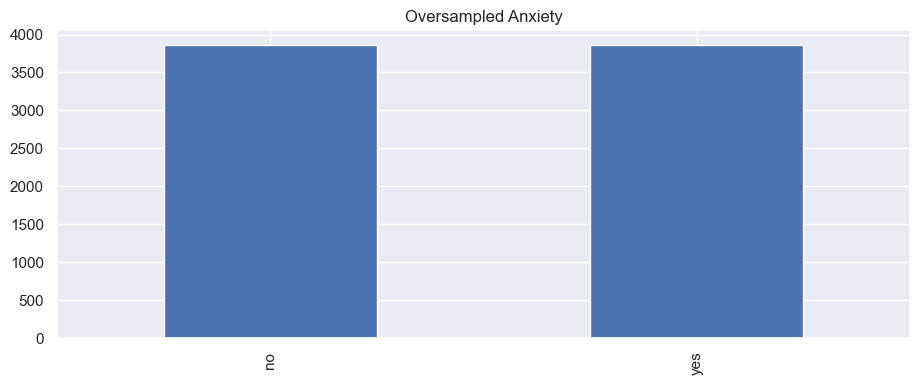

In [28]:
anxiety_os.value_counts().plot(kind='bar')
plt.title('Oversampled Anxiety')
plt.show()


# 1. Important Features (Chi-Squares)

In [29]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

In [30]:
k = 20  # Number of top features to select
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X_anxiety, anxiety_os)

In [31]:
selected_feature_indices_anx = selector.get_support(indices=True)

In [32]:
selected_feature_names_anx = X.columns[selected_feature_indices_anx]

In [33]:
chi2_scores = selector.scores_[selected_feature_indices_anx]

In [34]:
feature_importance_anx_chi2 = pd.DataFrame({'Anxiety Features': selected_feature_names_anx, 'Chi2 Score': chi2_scores})
feature_importance_anx_chi2 = feature_importance_anx_chi2.sort_values(by='Chi2 Score', ascending=False)

# Print the feature importance results
feature_importance_anx_chi2.head(20)

,Anxiety Features,Chi2 Score
1,Gender,692.023941
2,Field of study,257.766729
13,Having only one parent,222.830745
17,Abnormal heart rate,184.160656
5,Grant,178.848601
18,Drinker (3 levels),177.245688
12,Parental home,162.084830
3,Year of university,160.939197
11,Binge drinking,137.663212
16,Prehypertension or hypertension,119.290323


# 2. Important Features (Random Forest)

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_anxiety, anxiety_os)

feature_importances_anx_RF = pd.DataFrame({'Anxiety Features': X_anxiety.columns, 'Importance': rf.feature_importances_})
feature_importances_anx_RF = feature_importances_anx_RF.sort_values(by='Importance', ascending=False)

# Print the feature importance results
print(feature_importances_anx_RF.head(20))

               Anxiety Features  Importance
2                            PP    0.096359
1                           MAP    0.090994
5                        Gender    0.075850
3              Heart rate (bpm)    0.068483
0                           BMI    0.067226
7                Field of study    0.048355
4                Age (4 levels)    0.033715
43                Parental home    0.032273
54           Drinker (3 levels)    0.031266
46       Mode of transportation    0.026543
17                        Grant    0.023852
44       Having only one parent    0.023607
51       Vaccination up to date    0.021322
26  Physical activity(3 levels)    0.020447
15                     Siblings    0.020407
45                 Long commute    0.019407
23             Eating junk food    0.017891
47    Private health insurance     0.017380
52  Cigarette smoker (5 levels)    0.017369
19     Public health insurance     0.016772


# 3. Important Features (ANOVA)

In [37]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

# Perform ANOVA for all features
anova_results = {}
for feature in X_anxiety.columns:
    f_statistic, p_value = f_oneway(*[X_anxiety[anxiety_os == group][feature] for group in np.unique(anxiety_os)])
    anova_results[feature] = {'F-Statistic': f_statistic, 'P-value': p_value}

# Sort the features based on F-statistic in descending order
sorted_features = sorted(anova_results.items(), key=lambda x: x[1]['F-Statistic'], reverse=True)

# Select the top 20 features with non-NaN values
top_20_features = []
for feature, values in sorted_features:
    if not np.isnan(values['F-Statistic']) and not np.isnan(values['P-value']):
        top_20_features.append(feature)
        if len(top_20_features) == 20:
            break

# Create a dataframe to store the top 20 features and their ANOVA results
top_20_df = pd.DataFrame(columns=['Feature', 'F-Statistic', 'P-value'])
for feature in top_20_features:
    f_statistic = anova_results[feature]['F-Statistic']
    p_value = anova_results[feature]['P-value']
    top_20_df = top_20_df.append({'Feature': feature, 'F-Statistic': f_statistic, 'P-value': p_value}, ignore_index=True)

# Print the top 20 features and their corresponding F-statistic and p-value
print(top_20_df)

                             Feature  F-Statistic        P-value
0                             Gender  1098.717745  2.116726e-225
1                 Drinker (3 levels)   407.378340   2.497887e-88
2                      Parental home   351.646952   9.196248e-77
3             Having only one parent   305.257911   4.525888e-67
4                     Field of study   295.323507   5.484693e-65
5             Vaccination up to date   252.014942   7.162111e-56
6                              Grant   241.245789   1.350089e-53
7                           Siblings   221.108519   2.479649e-49
8                Abnormal heart rate   196.544067   4.100940e-44
9                 French nationality   150.367184   2.994406e-34
10         Private health insurance    149.254640   5.186398e-34
11                    Binge drinking   143.774623   7.772691e-33
12            Overweight and obesity   136.284176   3.158056e-31
13         Irregular rhythm of meals   133.762408   1.100384e-30
14                      L

# MODELLING With Chi Square Features

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Select the top 20 features from the 'feature_importance_Chi2' dataframe
top_20_features = feature_importance_anx_chi2.head(20)['Anxiety Features'].tolist()

# Create the feature matrix 'X' using the top 20 features
X_anx_chi2 = X_anxiety[top_20_features]

# Create the target variable 'y'
y_anx_chi2 = anxiety_os

# Split the data into training and testing sets
X_train_anx_chi2, X_test_anx_chi2, y_train_anx_chi2, y_test_anx_chi2 = train_test_split(X_anx_chi2, y_anx_chi2, test_size=0.3, random_state=42)

In [39]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_anx_chi2 = label_encoder.fit_transform(y_train_anx_chi2)

# Transform the test set
y_test_encoded_anx_chi2 = label_encoder.transform(y_test_anx_chi2)


In [40]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on the training data
rf_classifier.fit(X_train_anx_chi2, y_train_encoded_anx_chi2)

RandomForestClassifier()

In [41]:
# Predict on the test data
y_pred_anx_chi2 = rf_classifier.predict(X_test_anx_chi2)

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_anx_chi2, y_pred_anx_chi2)

# Calculate precision score
precision = precision_score(y_test_encoded_anx_chi2, y_pred_anx_chi2)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_anx_chi2, y_pred_anx_chi2)

# Calculate F1 score
f1 = f1_score(y_test_encoded_anx_chi2, y_pred_anx_chi2)

# Print the results
print("AUC score for Anxiety:", auc_score)
print("Precision for Anxiety:", precision)
print("Accuracy for Anxiety:", accuracy)
print("F1 score for Anxiety:", f1)

AUC score for Anxiety: 0.8706668032914696
Precision for Anxiety: 0.8460304731355253
Accuracy for Anxiety: 0.8707453683757002
F1 score for Anxiety: 0.8755186721991701


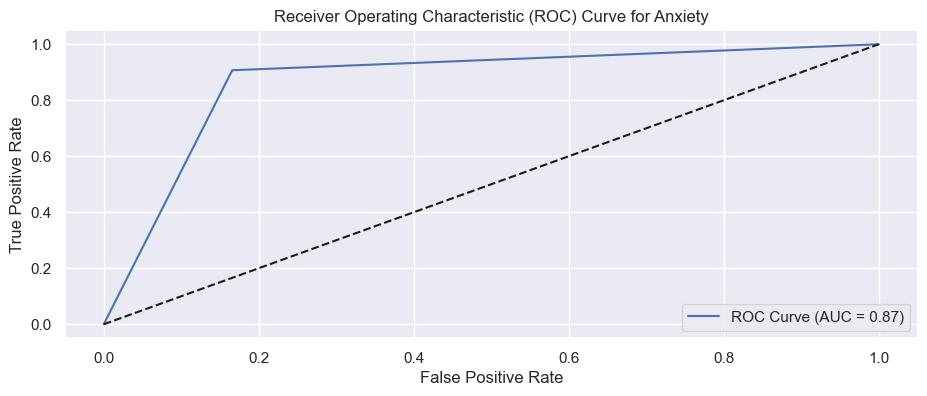

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_anx_chi2, y_pred_anx_chi2)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_anx_chi2, y_pred_anx_chi2)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Anxiety')
plt.legend(loc='lower right')
plt.show()


# MODELLING With RF Features

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Select the top 20 features from the 'feature_importance_Chi2' dataframe
top_20_features = feature_importances_anx_RF.head(20)['Anxiety Features'].tolist()

# Create the feature matrix 'X' using the top 20 features
X_anx_RF = X_anxiety[top_20_features]

# Create the target variable 'y'
y_anx_RF = anxiety_os

# Split the data into training and testing sets
X_train_anx_RF, X_test_anx_RF, y_train_anx_RF, y_test_anx_RF = train_test_split(X_anx_RF, y_anx_RF, test_size=0.3, random_state=42)

In [45]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_anx_RF = label_encoder.fit_transform(y_train_anx_RF)

# Transform the test set
y_test_encoded_anx_RF = label_encoder.transform(y_test_anx_RF)


In [46]:
# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier on the training data
rf_classifier.fit(X_train_anx_RF, y_train_encoded_anx_RF)

RandomForestClassifier()

In [47]:
# Predict on the test data
y_pred_anx_RF = rf_classifier.predict(X_test_anx_RF)

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_anx_RF, y_pred_anx_RF)

# Calculate precision score
precision = precision_score(y_test_encoded_anx_RF, y_pred_anx_RF)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_anx_RF, y_pred_anx_RF)

# Calculate F1 score
f1 = f1_score(y_test_encoded_anx_RF, y_pred_anx_RF)

# Print the results
print("AUC score for Anxiety:", auc_score)
print("Precision for Anxiety:", precision)
print("Accuracy for Anxiety:", accuracy)
print("F1 score for Anxiety:", f1)

AUC score for Anxiety: 0.925022684172462
Precision for Anxiety: 0.9215686274509803
Accuracy for Anxiety: 0.9250323136579061
F1 score for Anxiety: 0.925513698630137


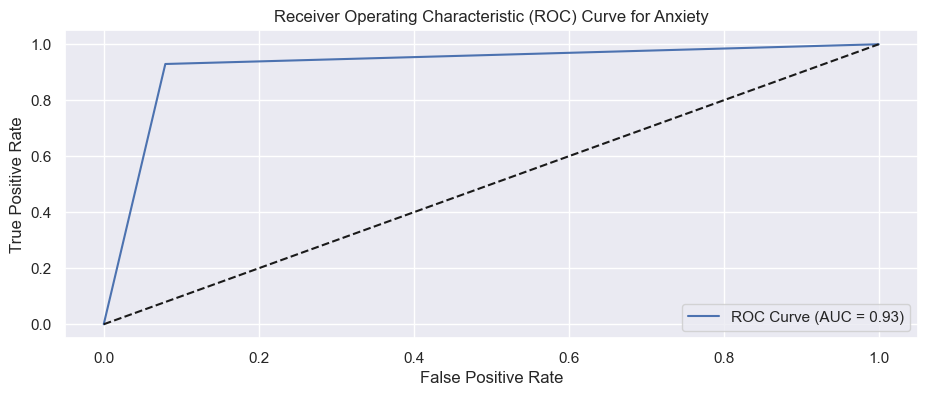

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_anx_RF, y_pred_anx_RF)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_anx_RF, y_pred_anx_RF)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Anxiety')
plt.legend(loc='lower right')
plt.show()

# MODELLING With ANOVA Square Features

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select the top 20 features
selected_features = top_20_df['Feature'].tolist()

# Create the feature matrix X and target variable y
X = X_anxiety[selected_features]
y = anxiety_os

# Split the data into training and testing sets
X_train_anx_ANOVA, X_test_anx_ANOVA, y_train_anx_ANOVA, y_test_anx_ANOVA = train_test_split(X, y, test_size=0.3, random_state=42)


In [51]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded_anx_ANOVA = label_encoder.fit_transform(y_train_anx_ANOVA)

# Transform the test set
y_test_encoded_anx_ANOVA = label_encoder.transform(y_test_anx_ANOVA)

In [52]:
# Create an instance of RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_anx_ANOVA, y_train_encoded_anx_ANOVA)

RandomForestClassifier(random_state=42)

In [53]:
# Predict on the test data
y_pred_anx_ANOVA = rf_classifier.predict(X_test_anx_ANOVA)

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, accuracy_score, f1_score

# Calculate AUC score
auc_score = roc_auc_score(y_test_encoded_anx_ANOVA, y_pred_anx_ANOVA)

# Calculate precision score
precision = precision_score(y_test_encoded_anx_ANOVA, y_pred_anx_ANOVA)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded_anx_ANOVA, y_pred_anx_ANOVA)

# Calculate F1 score
f1 = f1_score(y_test_encoded_anx_ANOVA, y_pred_anx_ANOVA)

# Print the results
print("AUC score for Anxiety with ANOVA:", auc_score)
print("Precision for Anxiety with ANOVA:", precision)
print("Accuracy for Anxiety with ANOVA:", accuracy)
print("F1 score for Anxiety with ANOVA:", f1)

AUC score for Anxiety with ANOVA: 0.8776439498230559
Precision for Anxiety with ANOVA: 0.8798617113223854
Accuracy for Anxiety with ANOVA: 0.8776389487289962
F1 score for Anxiety with ANOVA: 0.8775862068965518


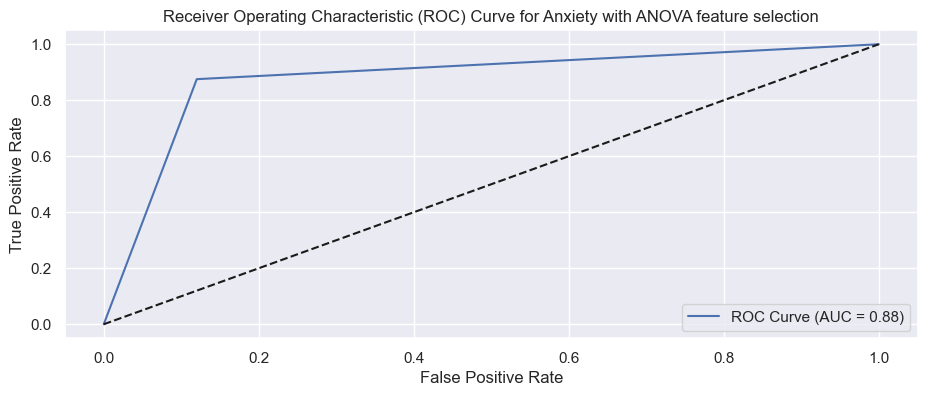

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_encoded_anx_ANOVA, y_pred_anx_ANOVA)

# Compute the AUC score
auc_score = roc_auc_score(y_test_encoded_anx_ANOVA, y_pred_anx_ANOVA)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Add the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Anxiety with ANOVA feature selection')
plt.legend(loc='lower right')
plt.show()